In [1]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 58kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/*.npy .
!cp gdrive/My\ Drive/*.py .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 5395456
-rw------- 1 root root       2875 Mar 21 10:44 _dataset_tools.py
drwx------ 3 root root       4096 Mar 21 10:42 gdrive
-rw------- 1 root root       1987 Mar 21 10:44 _my_tools.py
drwxr-xr-x 1 root root       4096 Mar  8 17:26 sample_data
-rw------- 1 root root  920825984 Mar 21 10:43 X_test.npy
-rw------- 1 root root 2762440832 Mar 21 10:43 X_train.npy
-rw------- 1 root root  460413056 Mar 21 10:44 y_test.npy
-rw------- 1 root root 1381220480 Ma

In [0]:
import tensorflow as tf
from tensorflow import keras
import _my_tools as mt
import numpy as np

def compareRes(i,folder=None):
    mt.showImgGC(str(i).zfill(2),X_test[i,:,:,0],y_test[i,:,:,0],res[i,:,:,0],X_test[i,:,:,1],folder=folder)
    
def compareResT(i,folder=None):
    mt.showImgGC(str(i).zfill(2),X_train[i,:,:,0],y_train[i,:,:,0],res[i,:,:,0],X_train[i,:,:,1],folder=folder)
    
def compare(i,X,y,res,folder=None):
    mt.showImgGC(str(i).zfill(2),X[i,:,:,0],y[i,:,:,0],res[i,:,:,0],X[i,:,:,1],folder=folder)

In [0]:
X_train, y_train, X_test, y_test = mt.loadData("",'float16')
# X_train = np.load("X_train.npy")
# y_train = np.load("y_train.npy")
# X_test = np.load("X_test.npy")
# y_test = np.load("y_test.npy")

# X_train = X_train.astype('float16')
# y_train = y_train.astype('float16')
# X_test = X_test.astype('float16')
# y_test = y_test.astype('float16')
# X_train /= 255
# y_train /= 255
# X_test /= 255
# y_test /= 255

In [0]:
X_train = X_train.swapaxes(1,3)
X_train = X_train.swapaxes(1,2)
X_test = X_test.swapaxes(1,3)
X_test = X_test.swapaxes(1,2)

y_train = np.expand_dims(y_train,3)
y_test = np.expand_dims(y_test,3)

In [0]:
def test_lambda(x):
  tmp = tf.math.scalar_mul(30,x)
  a = tf.math.floor(tmp)
  b = tf.math.ceil(tmp)
  res = tf.math.divide(tf.math.floordiv(tf.math.add(a,b),3),15)
  return tmp

def convBlock(x, depth):
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  l = keras.layers.MaxPooling2D((2,2),padding='same')(l)
  
  return l

def deconvBlock(x, depth):
  l = keras.layers.Conv2DTranspose(depth,(4,4),strides=2,padding='same',activation='relu')(x)
  l = keras.layers.Conv2D(depth,(3,3),activation='relu',padding='same')(l)
  
  return l
  


input_img = keras.layers.Input((96,96,2))

c1 = convBlock(input_img, 32)
c2 = convBlock(c1, 64)
c3 = convBlock(c2, 128)
c4 = convBlock(c3, 256)
# encoded = convBlock(c4, 512)

# d4 = deconvBlock(c4,256)
# d4 = keras.layers.Add()([c4,d4])
# d4 = keras.layers.ReLU()(d4)
# --
d3 = deconvBlock(c4, 128)
d3 = keras.layers.Add()([c3,d3])
d3 = keras.layers.ReLU()(d3)
# --
d2 = deconvBlock(d3, 64)
d2 = keras.layers.Add()([c2,d2])
d2 = keras.layers.ReLU()(d2)
# --
d1 = deconvBlock(d2, 32)
d1 = keras.layers.Add()([c1,d1])
d1 = keras.layers.ReLU()(d1)
# --
# decoded = deconvBlock(d1, 1)
l = keras.layers.Conv2DTranspose(1,(4,4),strides=2,padding='same',activation='relu')(d1)
decoded = keras.layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(l)
# decoded = keras.layers.Lambda(test_lambda)(decoded)
  
# out = keras.layers.Activation('sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_absolute_error')

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=False)

Using TensorFlow backend.


In [8]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 2)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 96, 96, 32)   608         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 96, 96, 32)   9248        conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

In [12]:
checkpoint_path = "09/cp"
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)

batch_size = 16
num_epoch = 2
#model training
model_log = autoencoder.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,          
          validation_data=(X_test, y_test),
          callbacks = [cp_callback])

Train on 149872 samples, validate on 49958 samples
Epoch 1/2
  1808/149872 [..............................] - ETA: 17:20 - loss: 13.2987

KeyboardInterrupt: ignored

In [15]:
import matplotlib.pyplot as plt

plt.plot(model_log.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


# model_log.history.keys()

NameError: ignored

In [14]:
autoencoder.load_weights("09/cp")

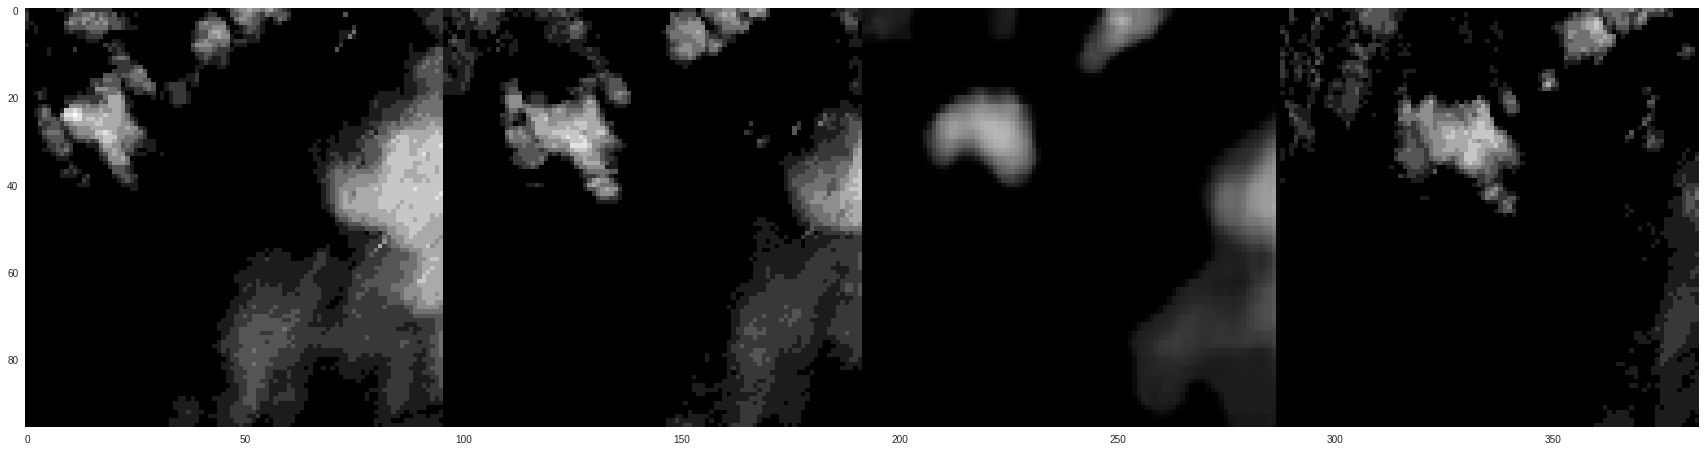

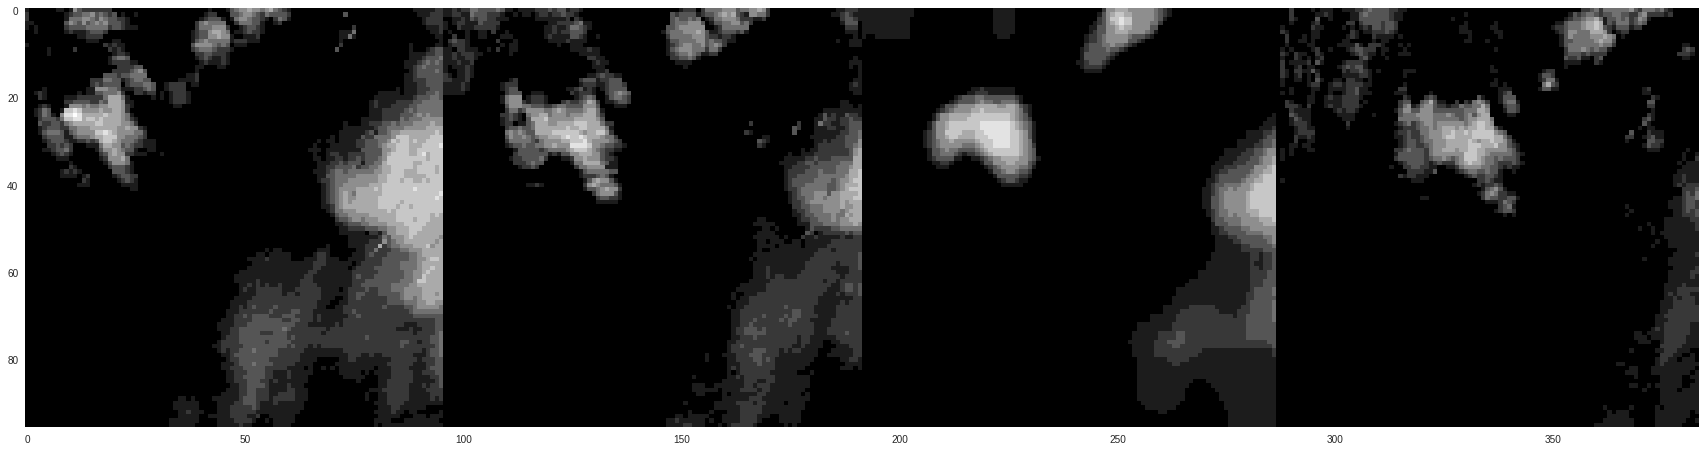

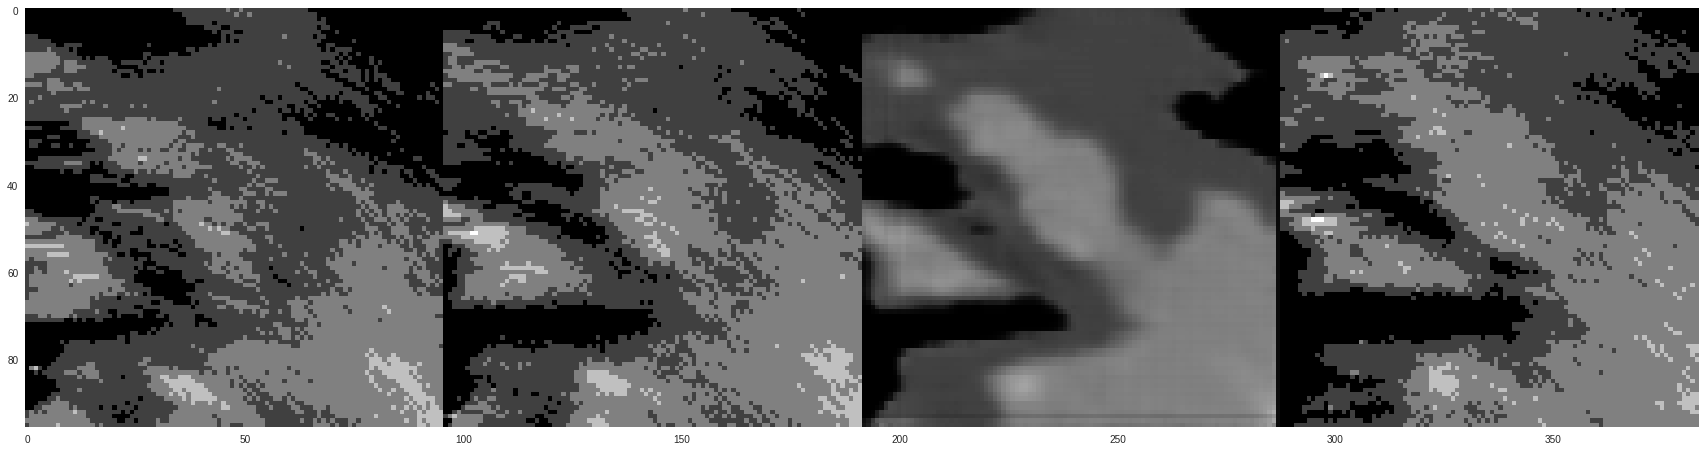

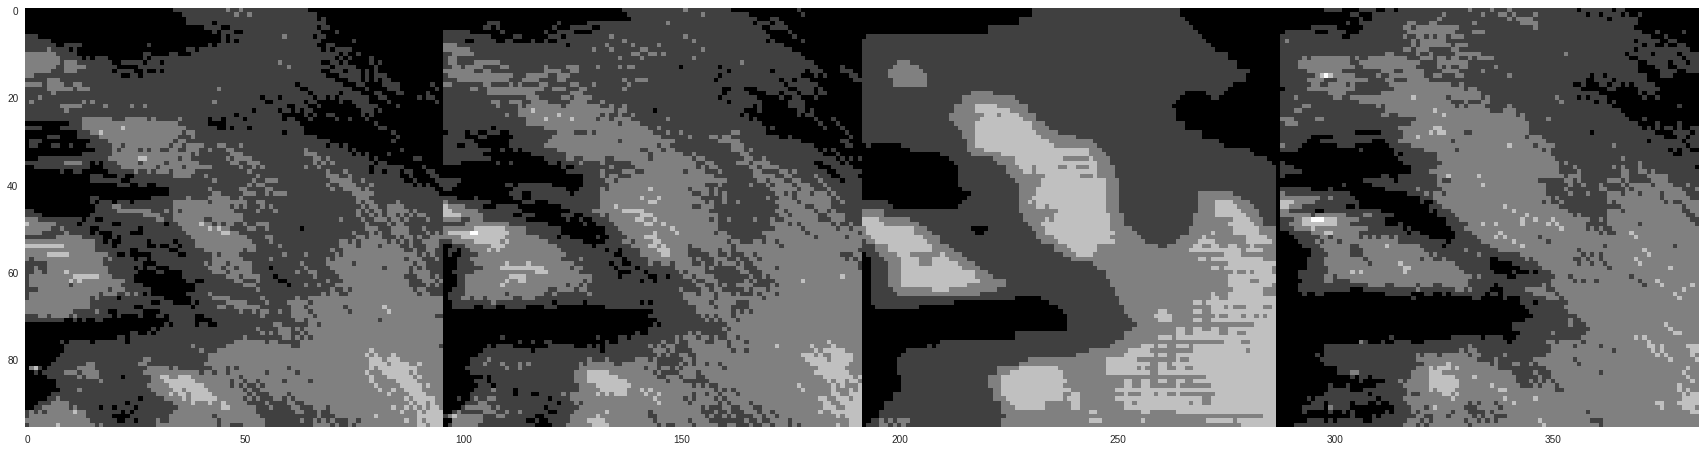

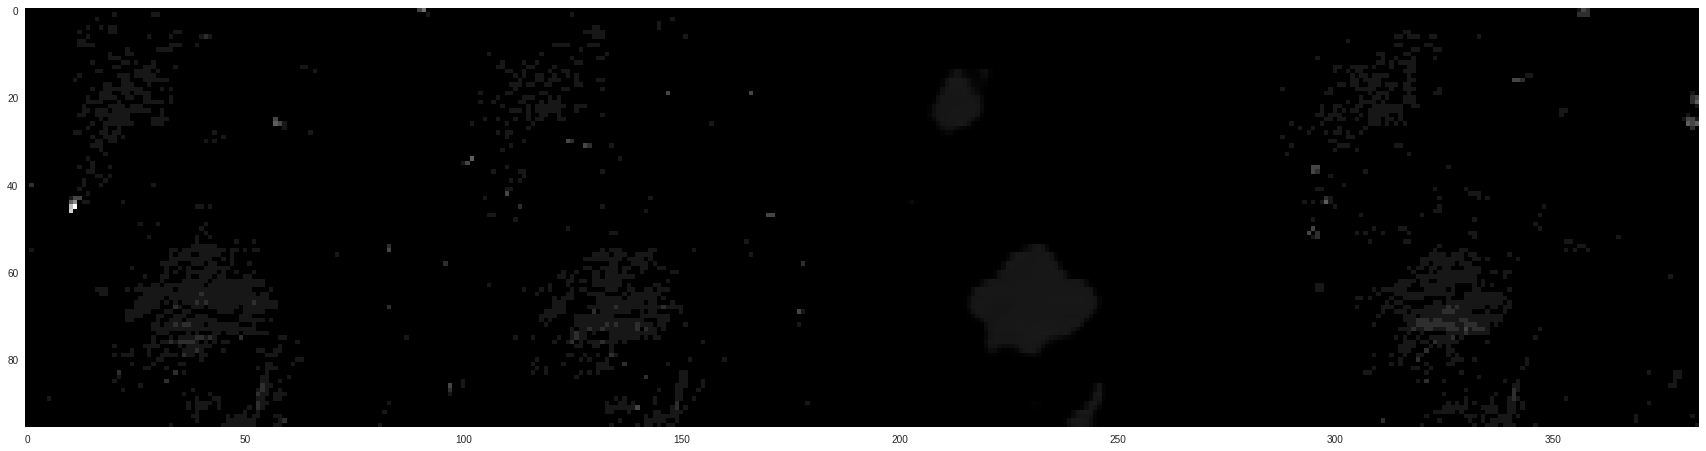

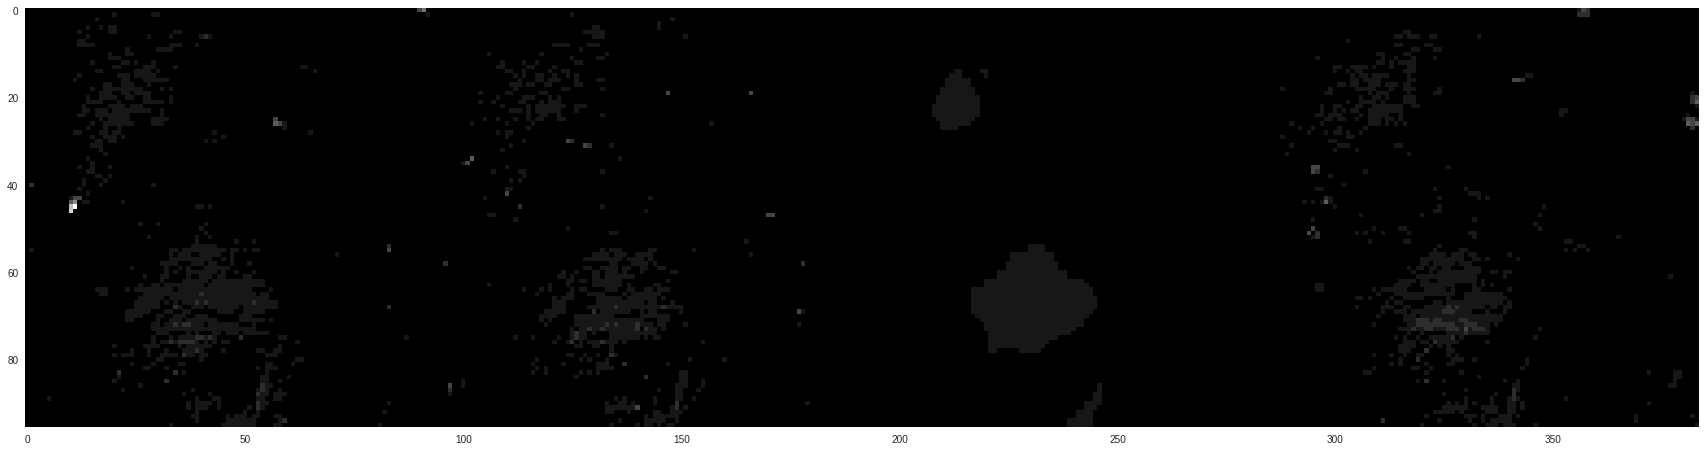

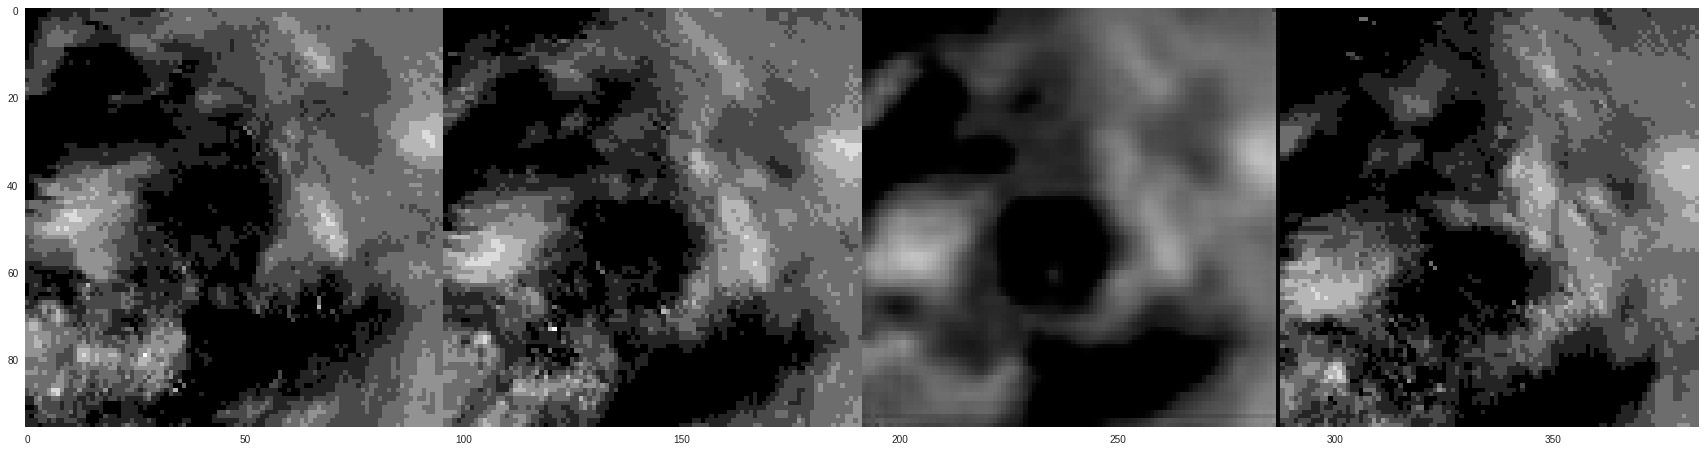

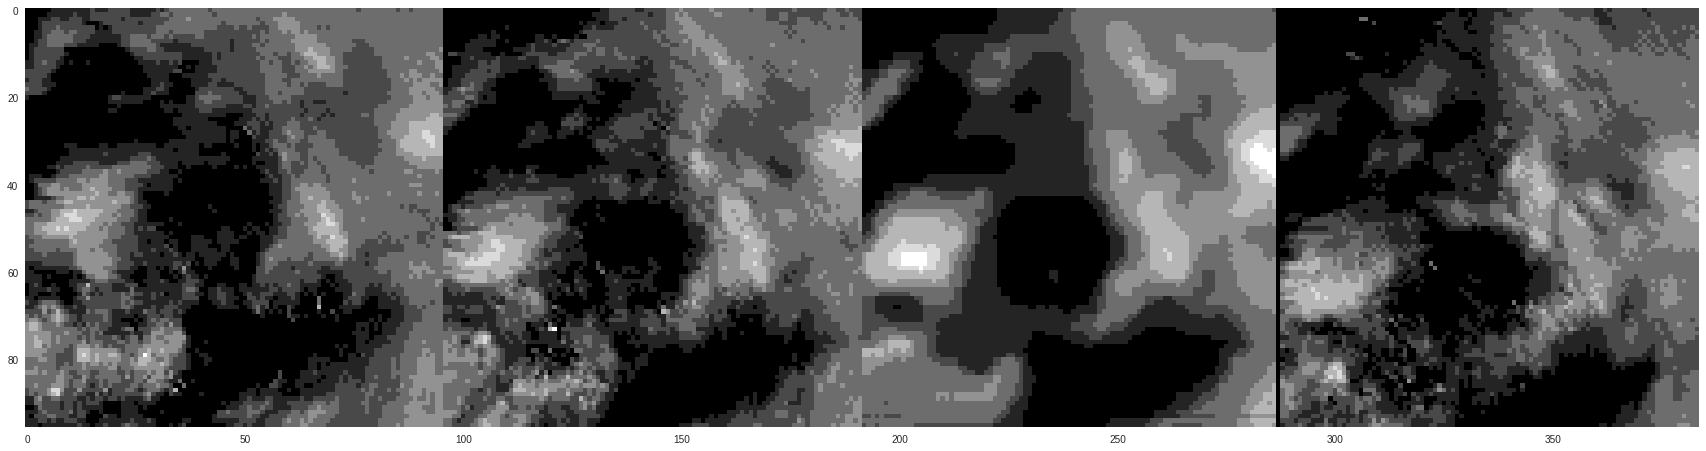

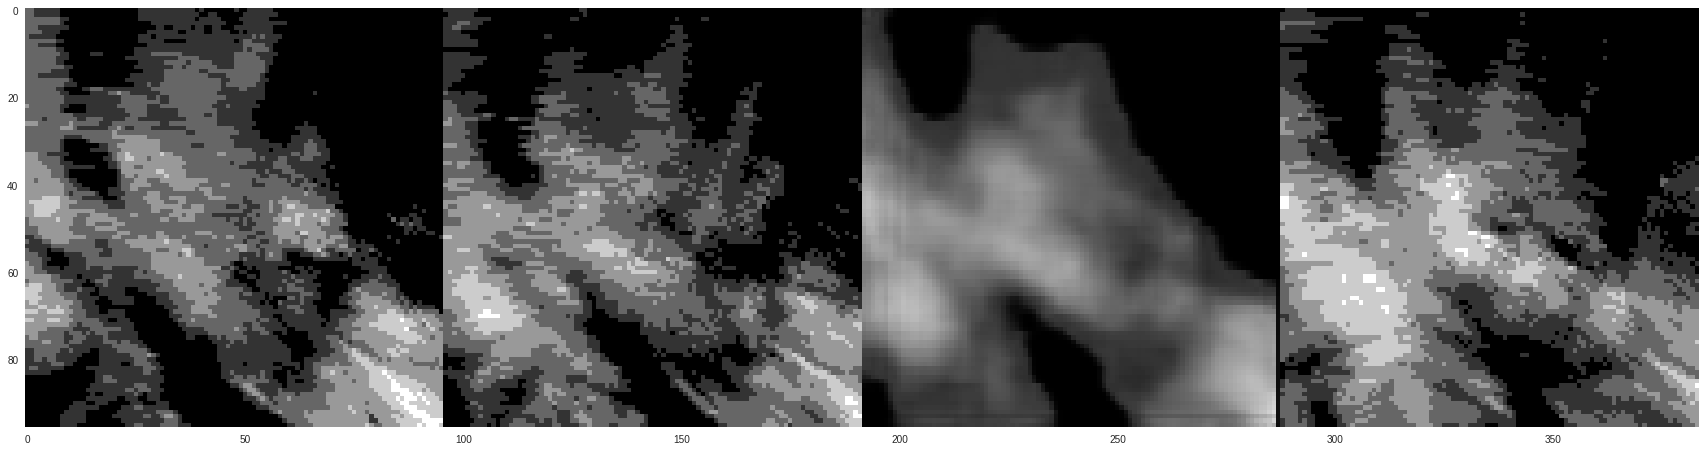

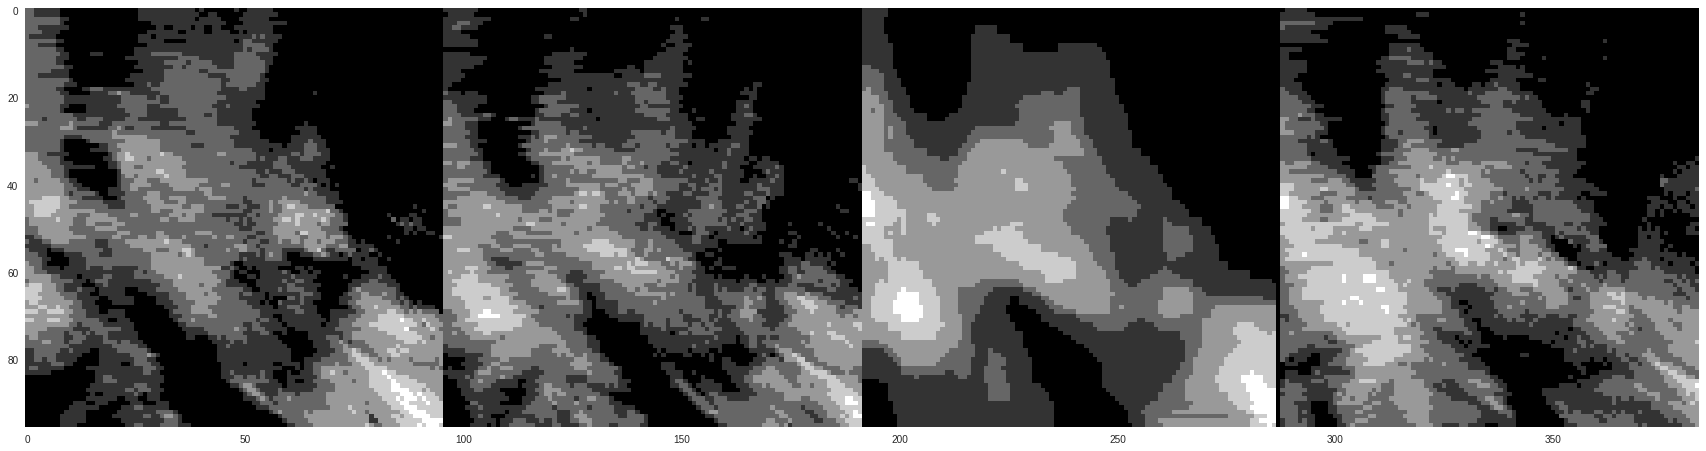

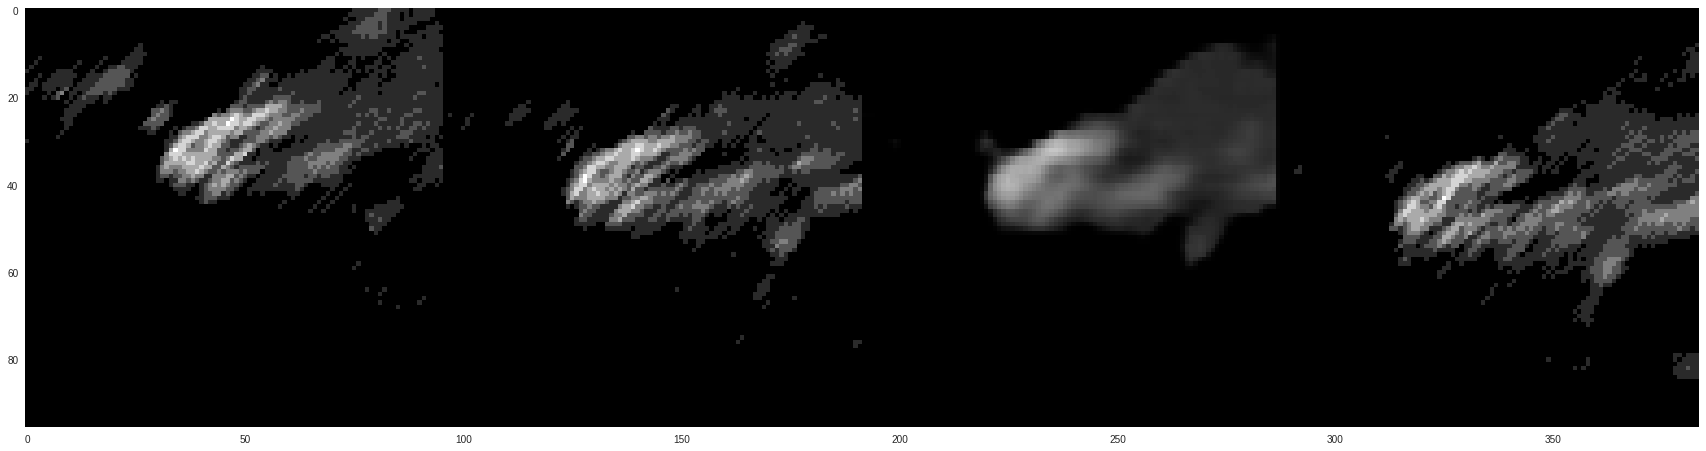

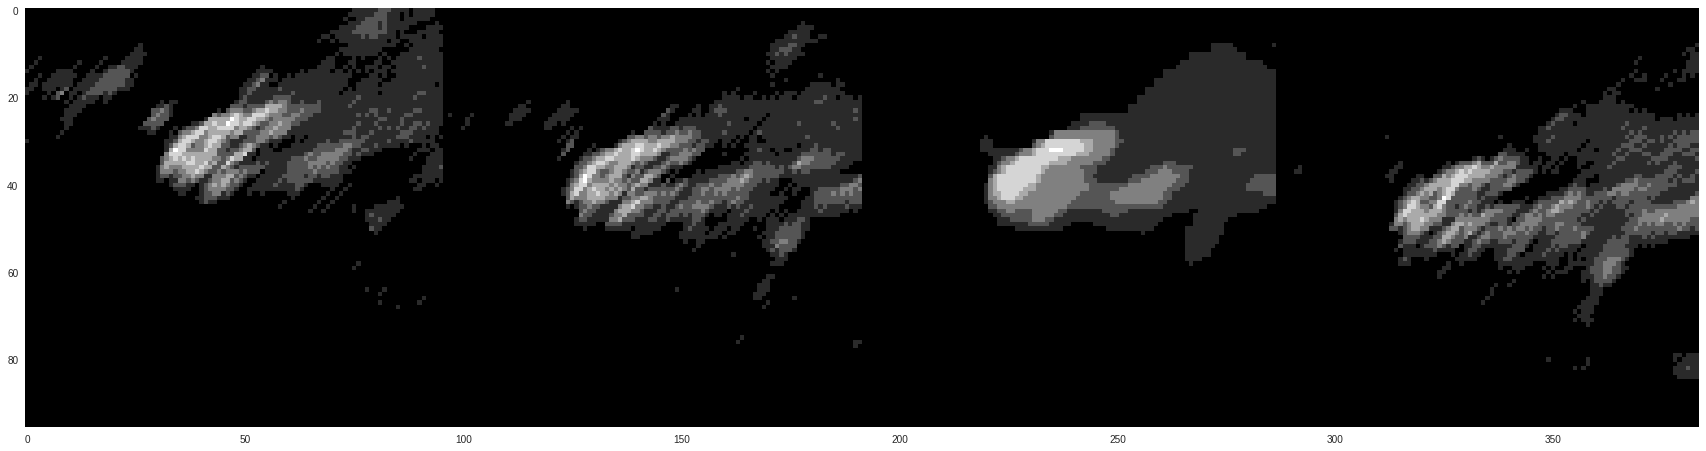

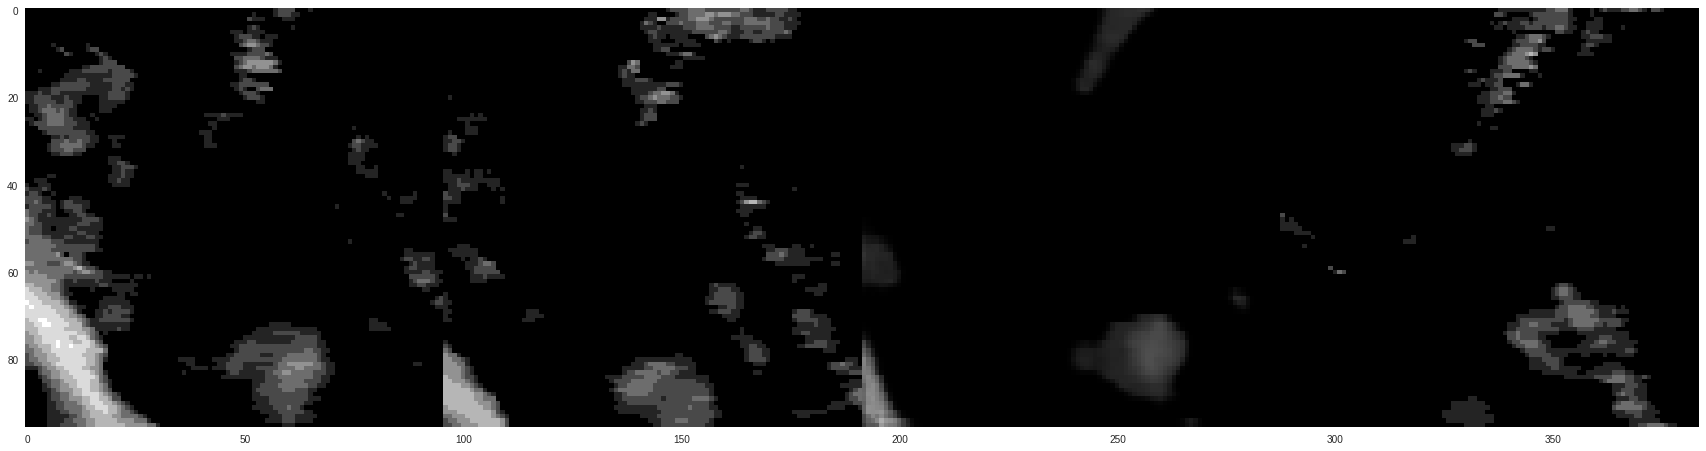

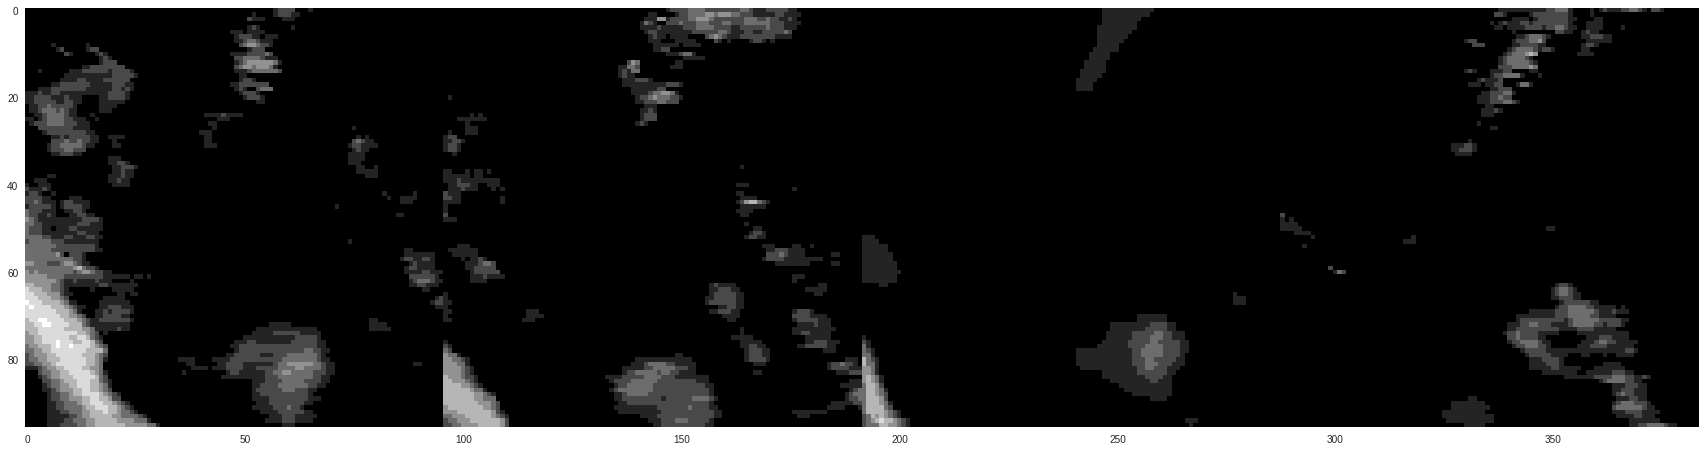

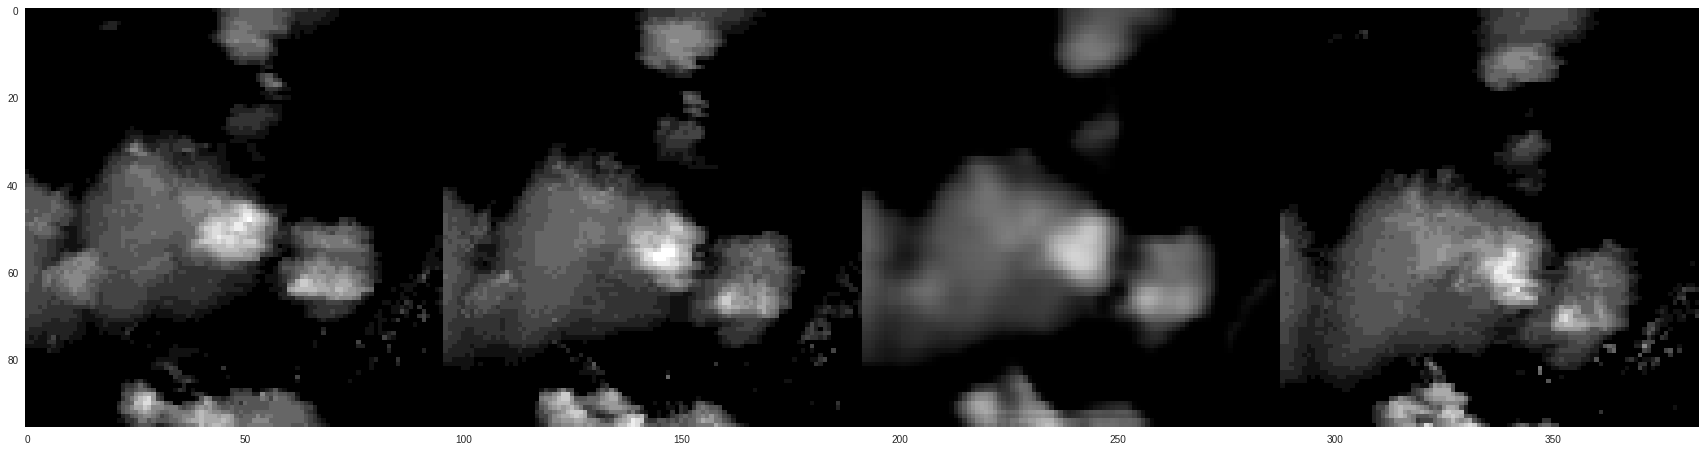

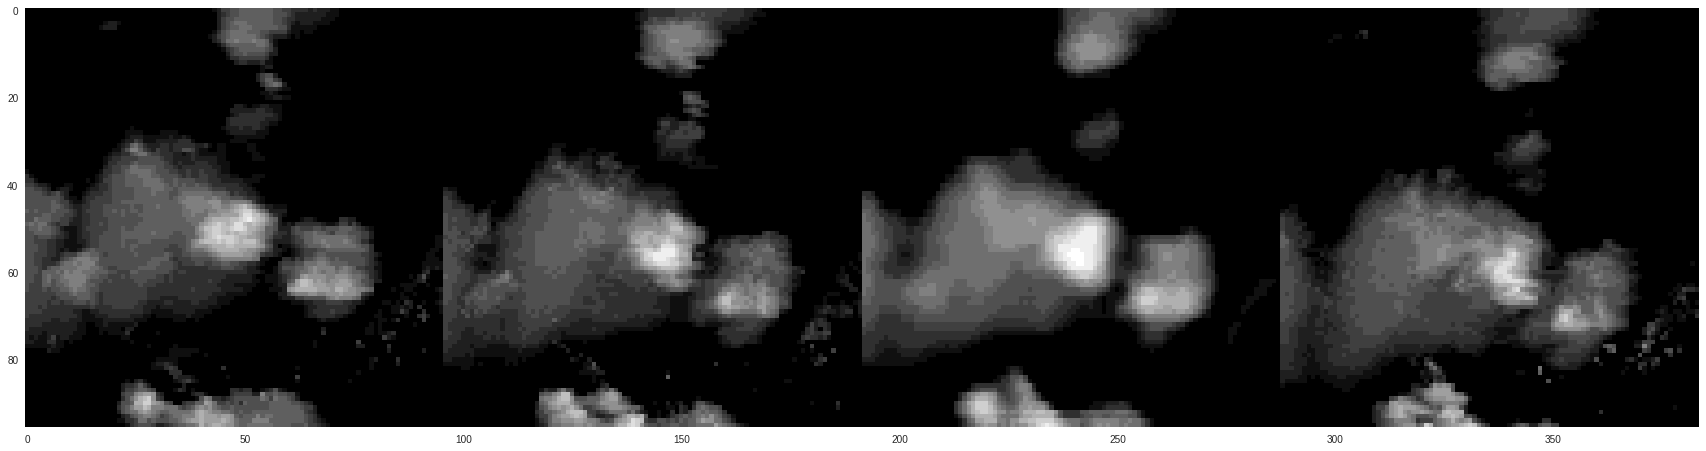

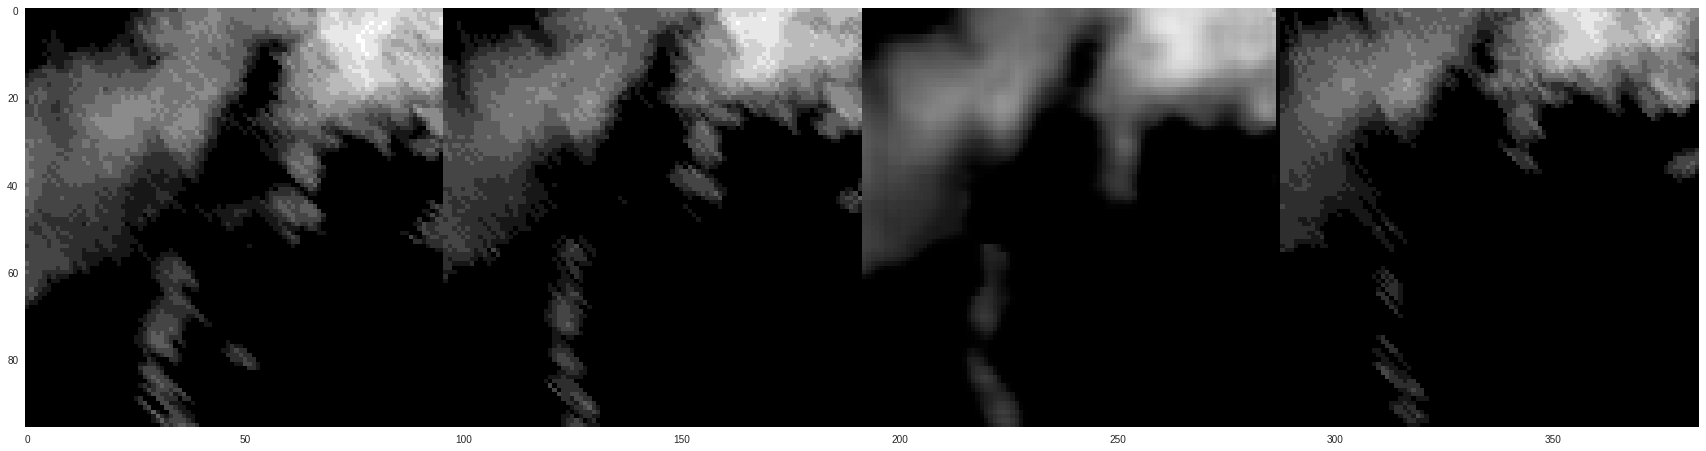

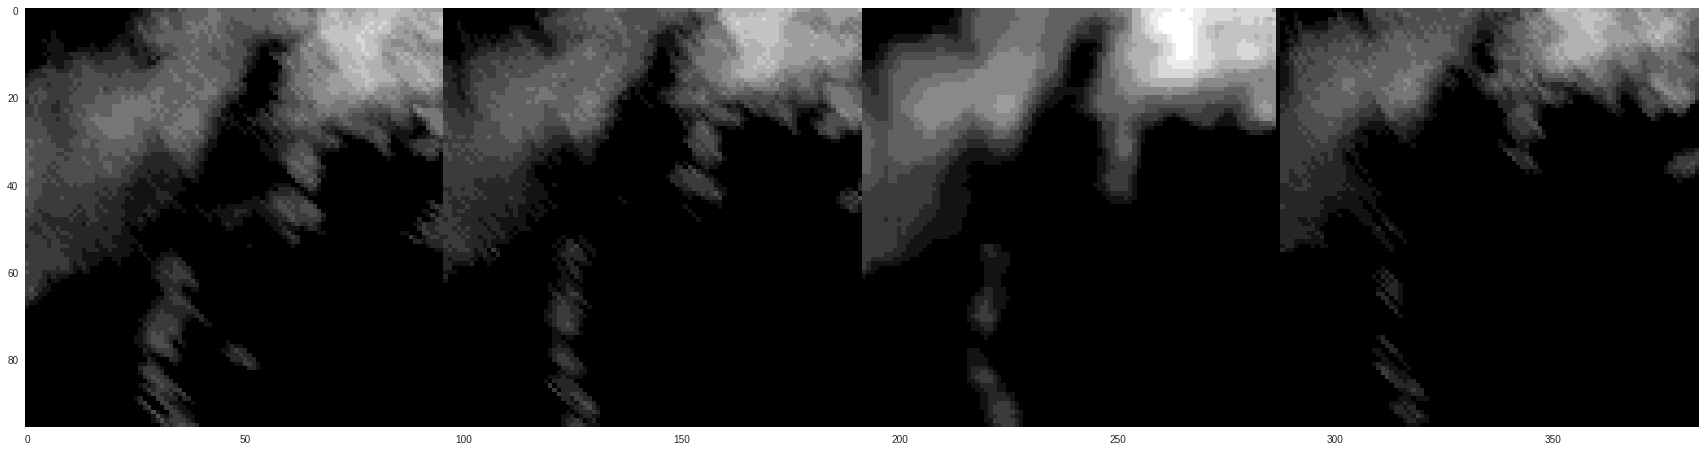

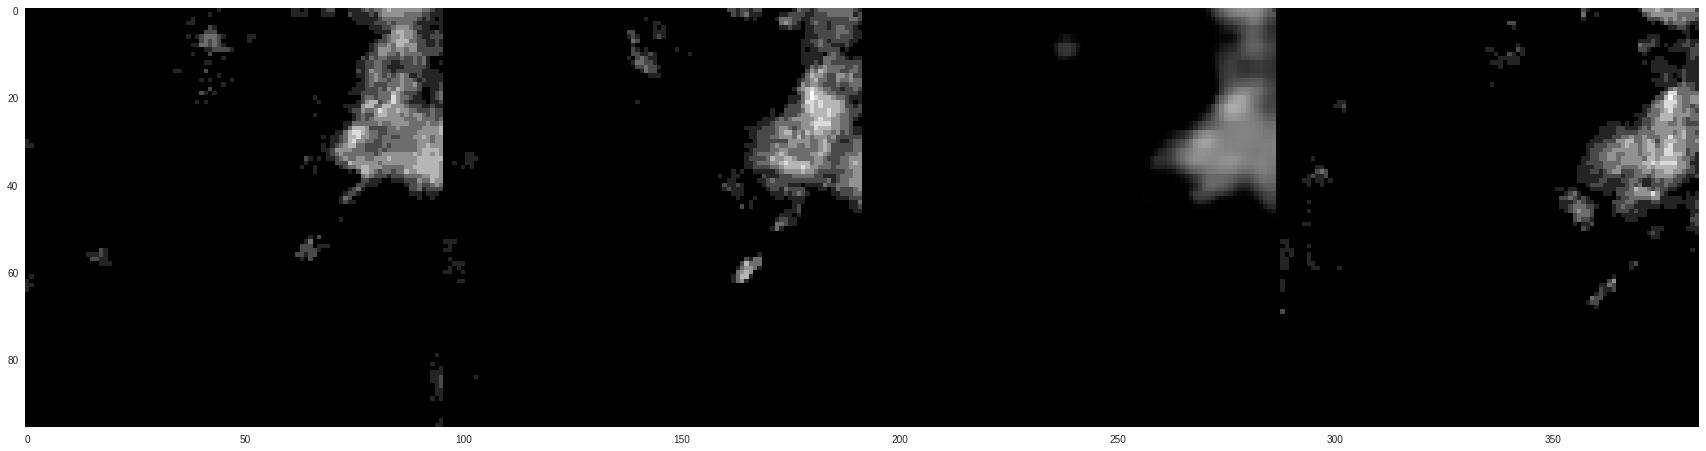

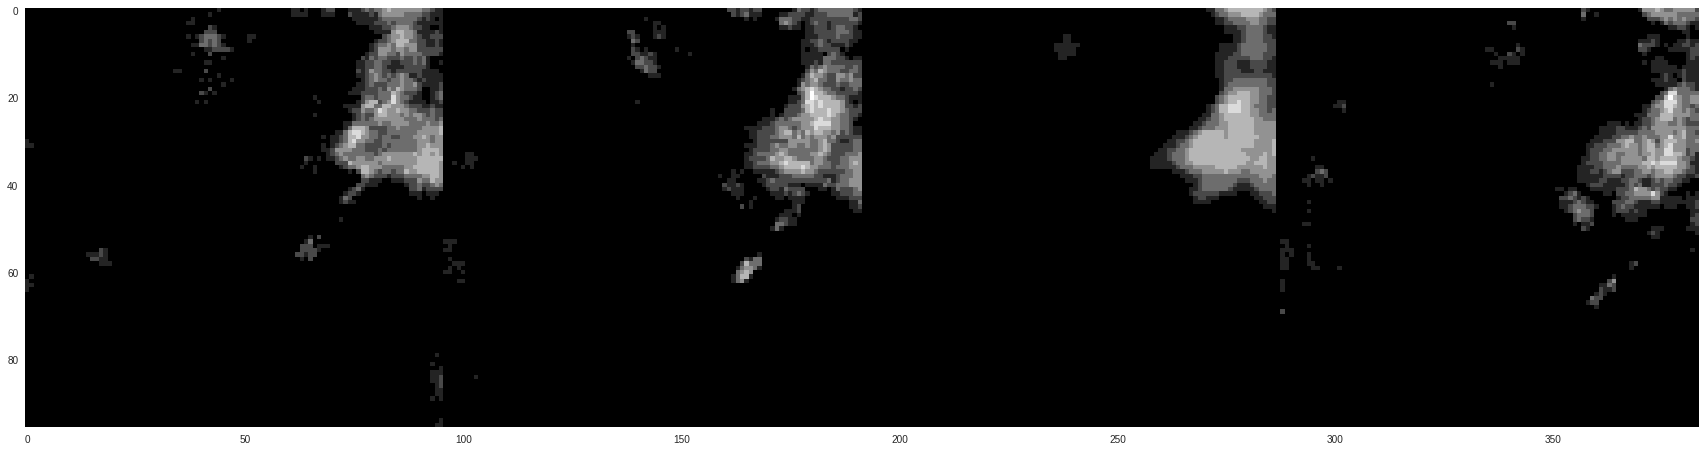

In [26]:
def test_py(x):
  tmp = x * 30
  a = np.floor(tmp)
  b = np.ceil(tmp)
  res = ((a+b)//3)/15
  return res


N = 10

res = autoencoder.predict(X_test[:10])
res2 = test_py(res)

for i in range(10):
  compare(i,X_test,y_test,res,"")
  compare(i,X_test,y_test,res2)
  

In [27]:
!zip fig.zip *.png

updating: 00.png (deflated 1%)
updating: 01.png (deflated 4%)
updating: 02.png (deflated 1%)
updating: 03.png (deflated 2%)
updating: 04.png (deflated 3%)
updating: 05.png (deflated 1%)
updating: 06.png (deflated 1%)
updating: 07.png (deflated 0%)
updating: 08.png (deflated 2%)
updating: 09.png (deflated 0%)


In [0]:
!zip -r weights.zip 09/

  adding: 09/ (stored 0%)
  adding: 09/checkpoint (deflated 34%)
  adding: 09/cp.data-00000-of-00001 (deflated 8%)
  adding: 09/cp.index (deflated 69%)


In [10]:
!unzip weights.zip

Archive:  weights.zip
   creating: 09/
  inflating: 09/checkpoint           
  inflating: 09/cp.data-00000-of-00001  
  inflating: 09/cp.index             
